In [3]:
import torch
from torch import nn
from torchvision import transforms
from tqdm.auto import tqdm
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/home/maung/miniconda3/envs/dl/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [19]:
def show_tensor_image(image_tensor, num_images=25, size=(1, 28, 28)):
    unflat_tensor = (image_tensor.detach().cpu().view(-1, *size) + 1) / 2 #unnormalize
    grid_tensor = make_grid(unflat_tensor[:num_images], nrow=5)
    plt.imshow(grid_tensor.permute(1, 2, 0))
    plt.show()

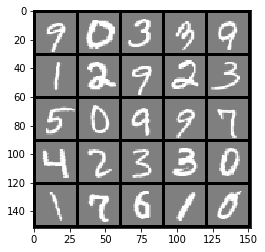

In [12]:
dataset = MNIST('.', download=False, transform=transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
X, y = iter(dataloader).next()
show_tensor_image(X)

In [24]:
class Generator(nn.Module):
    
    def __init__(self, z_dim=10, im_channels=1, hidden_dim=64):
        super().__init__()
        self.z_dim = z_dim
        self.gen  = nn.Sequential(
            self.make_generator_block(z_dim, hidden_dim * 4),
            self.make_generator_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_generator_block(hidden_dim * 2, hidden_dim),
            self.make_generator_block(hidden_dim, im_channels, kernel_size=4, final_layer=True)
        )
        
    def make_generator_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride=stride),
                nn.Tanh()
            )
        
    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)
    
    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

In [25]:
class Discriminator(nn.Module):
    
    def __init__(self, im_channels=1, hidden_dim=16):
        super().__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_channels, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim*2),
            self.make_disc_block(hidden_dim*2, 1, final_layer=True)
        )
    
    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride=stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(negative_slope=0.2)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride=stride)
            )
        
    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [27]:
torch.manual_seed(0)
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002

beta_1 = 0.5
beta_2 = 0.99

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('.', download=False, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

gen = Generator(z_dim).cuda()
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().cuda()
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
        
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [29]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.cuda()
        
        disc_opt.zero_grad()
        fake = gen(torch.randn(cur_batch_size, z_dim).cuda())
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        mean_discriminator_loss += disc_loss.item() / display_step
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        
        gen_opt.zero_grad()
        fake2 = gen(torch.randn(cur_batch_size, z_dim).cuda())
        pred = disc(fake2)
        gen_loss = criterion(pred, torch.ones_like(pred))
        gen_loss.backward()
        gen_opt.step()
        
        mean_generator_loss += gen_loss.item() / display_step
        
        if cur_step % display_step == 0 and cur_step > 0:
            print(f'Step: {cur_step}, Gen Loss: {mean_generator_loss}, Disc Loss: {mean_discriminator_loss}')
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

Step: 500, Gen Loss: 0.8333809188604355, Disc Loss: 0.543331589102745



Step: 1000, Gen Loss: 2.0040729150772094, Disc Loss: 0.19771671497821794



Step: 1500, Gen Loss: 2.80711863893271, Disc Loss: 0.16298489362746457



Step: 2000, Gen Loss: 2.2576030238121745, Disc Loss: 0.27070951367914686



Step: 2500, Gen Loss: 1.34231017163396, Disc Loss: 0.5308095960021023



Step: 3000, Gen Loss: 1.089289177298546, Disc Loss: 0.6038065774440765



Step: 3500, Gen Loss: 0.9369237026870254, Disc Loss: 0.6363301997184749



Step: 4000, Gen Loss: 0.8831968017220498, Disc Loss: 0.6425904676914208



Step: 4500, Gen Loss: 0.8607549331188203, Disc Loss: 0.6447922096252441



Step: 5000, Gen Loss: 0.8066814902424817, Disc Loss: 0.668202838420868



Step: 5500, Gen Loss: 0.7812991826534266, Disc Loss: 0.6746047158241265



Step: 6000, Gen Loss: 0.765331699848175, Disc Loss: 0.6821415086984639



Step: 6500, Gen Loss: 0.7347800246477123, Disc Loss: 0.6969570914506913



Step: 7000, Gen Loss: 0.7405180190205567, Disc Loss: 0.6885862795114512



Step: 7500, Gen Loss: 0.7308824673891071, Disc Loss: 0.6944093445539475



Step: 8000, Gen Loss: 0.7215153380036354, Disc Loss: 0.7007106560468672



Step: 8500, Gen Loss: 0.7145855125188828, Disc Loss: 0.6995061912536621



Step: 9000, Gen Loss: 0.712442534446716, Disc Loss: 0.6978747725486758



Step: 9500, Gen Loss: 0.7122012344002727, Disc Loss: 0.6993789511919027



Step: 10000, Gen Loss: 0.7045822650194165, Disc Loss: 0.6988329713344577



Step: 10500, Gen Loss: 0.703703911781311, Disc Loss: 0.6994286470413209



Step: 11000, Gen Loss: 0.7045221449136742, Disc Loss: 0.6980660395622258



Step: 11500, Gen Loss: 0.7044759709835053, Disc Loss: 0.6973437854051593



Step: 12000, Gen Loss: 0.7026067544221873, Disc Loss: 0.6972192052602769



Step: 12500, Gen Loss: 0.7005812817811956, Disc Loss: 0.6972801367044457



Step: 13000, Gen Loss: 0.6996583231687544, Disc Loss: 0.6974536124467854



Step: 13500, Gen Loss: 0.7025948143005368, Disc Loss: 0.6969168914556503



Step: 14000, Gen Loss: 0.7021582387685774, Disc Loss: 0.6956714364290231



Step: 14500, Gen Loss: 0.7011617325544359, Disc Loss: 0.6963933793306354



Step: 15000, Gen Loss: 0.7004357037544249, Disc Loss: 0.6961178675889965



Step: 15500, Gen Loss: 0.7010833870172504, Disc Loss: 0.6959332834482185



Step: 16000, Gen Loss: 0.6982978184223178, Disc Loss: 0.696200392842294



Step: 16500, Gen Loss: 0.698681875109673, Disc Loss: 0.6957611856460572



Step: 17000, Gen Loss: 0.6994434703588487, Disc Loss: 0.6954415394067767



Step: 17500, Gen Loss: 0.7003004324436192, Disc Loss: 0.6956093132495884



Step: 18000, Gen Loss: 0.6973839045763026, Disc Loss: 0.6954539618492123



Step: 18500, Gen Loss: 0.6975216571092605, Disc Loss: 0.6956560171842585



Step: 19000, Gen Loss: 0.697927971601486, Disc Loss: 0.6955881724357609



Step: 19500, Gen Loss: 0.6981034994125372, Disc Loss: 0.6951838890314104



Step: 20000, Gen Loss: 0.6979867501258857, Disc Loss: 0.6950710747241976



Step: 20500, Gen Loss: 0.6988181931972501, Disc Loss: 0.6950657215118403



Step: 21000, Gen Loss: 0.6972148147821426, Disc Loss: 0.6945876593589783



Step: 21500, Gen Loss: 0.6973271183967602, Disc Loss: 0.6945898399353027



Step: 22000, Gen Loss: 0.6970868632793424, Disc Loss: 0.6947231428623204



Step: 22500, Gen Loss: 0.6972982205152516, Disc Loss: 0.6944369696378709



Step: 23000, Gen Loss: 0.696937131047249, Disc Loss: 0.694625739216805



In [30]:
fake2 = gen(torch.randn(cur_batch_size, z_dim).cuda())

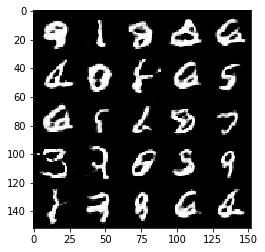

In [31]:
show_tensor_image(fake2)